In [27]:
!pip install gupload

In [28]:
import pandas as pd
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import gc
import pickle
import sys

In [29]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [30]:
#Read Preprocessed data
id_dataset = '1WJOAVBwFLw7odJFMLkjKsLJ-y8ndeFyL'
data = drive.CreateFile({'id':id_dataset})   
data.GetContentFile('data.pkl')

In [31]:
df = pd.read_pickle('data.pkl')

# Train / Validation

In [32]:
X_train = df[df["date_block_num"]<33].drop("target",axis=1)
X_val   = df[df["date_block_num"]==33].drop("target",axis=1)
X_test  = df[df["date_block_num"]==34].drop("target",axis=1)

y_train = df[df["date_block_num"]<33].target.clip(0,20)
y_val   = df[df["date_block_num"]==33].target.clip(0,20)

In [33]:
del df
gc.collect();

# RandomForest

In [34]:
rmse = make_scorer(mean_squared_error)

In [39]:
rf_params = {
    'n_estimators': range(50,500,50),
    'max_depth': range(6,12),
    'min_samples_leaf': range(10),
    'random_state': [42],
    'max_samples': np.linspace(0.5,0.85),
    'verbose':[2],
    'max_features':['auto','sqrt']
}

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_all = pd.concat([X_train, X_val, X_test])
pca.fit(X_all)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [37]:
del X_all
gc.collect();

In [ ]:
rf_randomized_search = {"PARAMS":["a"],"TRAIN_SCORE":[999], "VAL_SCORE":[999]}

n_iter = 11
best_model = []
for i in range(n_iter):
  print(f"Iteration: {i+1}")
  params = {}
  for x,y in rf_params.items():
      np.random.seed = 42
      #Randomized Search
      params[x] = np.random.choice(y)

  #Train the model
  rf = RandomForestRegressor(**params)
  rf.fit(X_train,y_train)
  train_score = np.sqrt(mean_squared_error(y_train,rf.predict(X_train)))
  val_score   = np.sqrt(mean_squared_error(y_val,rf.predict(X_val)))
  #Best Model
  if val_score < min(rf_randomized_search["VAL_SCORE"]):
    best_model = rf
  #Append values
  rf_randomized_search["PARAMS"].append(params)
  rf_randomized_search["TRAIN_SCORE"].append(train_score)
  rf_randomized_search["VAL_SCORE"].append(val_score)
  print(f"> Train Score: {train_score}\n> Validation Score: {val_score}")
  print("...............................")
  del rf, train_score, val_score
  gc.collect();

rf_randomized_search = pd.DataFrame(rf_randomized_search).drop(0)

Iteration: 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s


building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


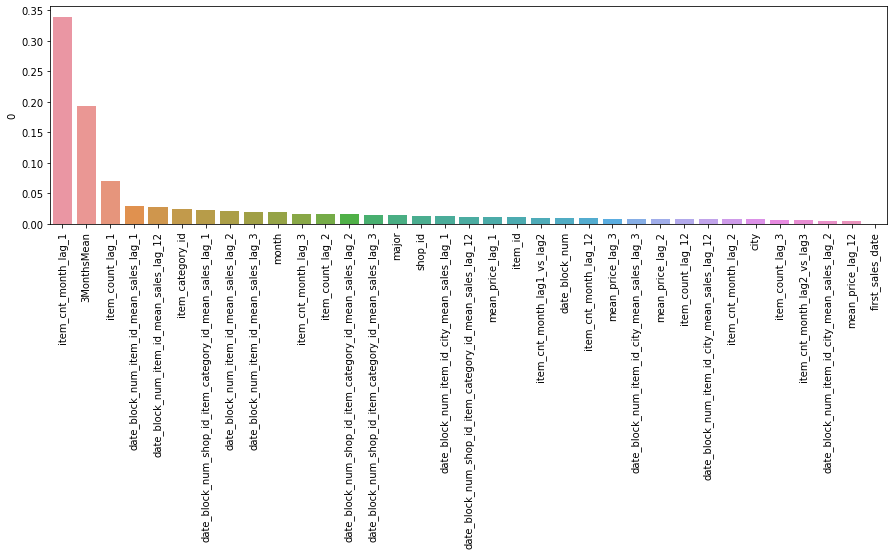

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
feat_importance = pd.DataFrame(best_model.feature_importances_/best_model.feature_importances_.sum()\
                                        , index=X_train.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(15,4))
sns.barplot(feat_importance.index, feat_importance[0])
plt.xticks(rotation=90);

In [ ]:
best_model.predict(X_test)

array([ 0.20595622,  0.5257707 ,  0.76170266, ...,  0.17199546,
       -0.03672618,  0.06336632], dtype=float32)

In [ ]:
#Read XGBoost
id_model = '11WOpZdBrvuHQtzzXaAsgmqDAObQYqMJK'
data = drive.CreateFile({'id':id_model})   
data.GetContentFile('xgb.pkl')
xgba = pickle.load(open('xgb.pkl', 'rb'))

In [ ]:
xgba.predict(X_test)

array([ 0.20595622,  0.5257707 ,  0.76170266, ...,  0.17199546,
       -0.03672618,  0.06336632], dtype=float32)

In [ ]:
pickle.dump(best_model,open("xgb.pkl",'wb'))

In [ ]:
!gupload --to '1fUe3r9HhiN576xtpLTxp7LBwIbK_mpqp' xgb.pkl

Uploading file: xgb.pkl
